## GeoPandas spatial join example

This is a simple example of how to do a spatial join between a data
set of (latitude, longitude) pairs to an Esri shapefile to get the census
tract ID for each lat/lon pair using the Python 
[GeoPandas](http://geopandas.org/)
module without having to use QGIS or ArcPro.

### Python GIS Module Installation

If you're using the Anaconda Python 3 
[standard](https://www.anaconda.com/distribution/) or 
[miniconda](https://docs.conda.io/en/latest/miniconda.html)
distribution, it's easier to get everything working without library conflicts if you
create a separate environment for this GIS work. In the Anaconda Prompt type

```
conda create --name GIS -c conda-forge geopandas fiona shapely
```

then to "activate" this environment, type

```
conda activate GIS
```

### Import modules

In [16]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Read in census tracts shapefile

This is the 2010 California, Los Angeles County shapefile, downloaded from [the US Census Bureau web interface](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts)

In [14]:
tracts = gpd.read_file('data/LA_CensusTracts/CENSUS_TRACTS_2000.shp')

tracts.head()

,CT00,LABEL,Shape_STAr,Shape_STLe,geometry
0,101110,1011.10,1.228537e+07,15056.954289,"POLYGON ((6475581.002 1916939.627, 6475580.499..."
1,101120,1011.20,1.364394e+08,70339.952869,"POLYGON ((6471660.000 1919631.502, 6471661.499..."
2,101210,1012.10,7.019669e+06,12082.404482,"POLYGON ((6473070.498 1913983.375, 6472914.850..."
3,101220,1012.20,7.485860e+06,12652.916695,"POLYGON ((6477593.248 1914091.178, 6477595.001..."
4,101300,1013.00,2.784498e+07,28343.215220,"POLYGON ((6480645.620 1906746.726, 6480594.842..."


### Read in Zipped (.zip) shapefile

If you know the file name and path within a zipped shapefile (set of files in a folder), you don't even have to unzip it before reading!

In [34]:
tracts.crs

{'proj': 'lcc',
 'lat_0': 33.5,
 'lon_0': -118,
 'lat_1': 34.0333333333333,
 'lat_2': 35.4666666666667,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

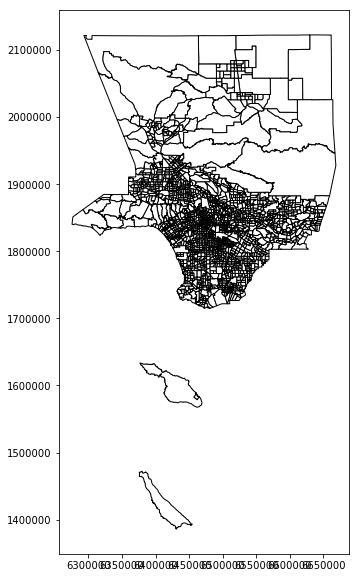

In [30]:
tracts.plot(color='white', edgecolor='black', figsize=(10,10));

## Read family data

This is a very small, attribute-randomized subset (rows and columns) of household data from [InfoUSA](https://www.infousa.com/). *It will be useless for research use, but works well for this example.*

- Be sure to read 'familyid' as a string or initial zeroes will be lost!
- Only reading in some of the columns for this operation

In [28]:
data_cols = ['familyid','longitude','latitude']
eth = pd.read_csv('data/la_family_data.csv', sep=',', usecols=data_cols, dtype={'familyid': 'str'})

print(eth.shape)
eth.head()

(10000, 3)


,familyid,latitude,longitude
0,000106617324,34.13613,-118.14349
1,000106679098,33.84097,-118.06158
2,000106273271,34.69933,-118.13906
3,000106308511,33.79798,-118.11764
4,000106431883,34.40821,-118.44098


### Lat/Lon pairs need to be converted to a Point() data type

We'll put these in a new column called `coordinates`

In [24]:
eth['coordinates'] = list(zip(eth['longitude'], eth['latitude']))
eth['coordinates'] = eth['coordinates'].apply(Point)

eth.head()

,familyid,latitude,longitude,coordinates
0,000106617324,34.13613,-118.14349,POINT (-118.14349 34.13613)
1,000106679098,33.84097,-118.06158,POINT (-118.06158 33.84097)
2,000106273271,34.69933,-118.13906,POINT (-118.13906 34.69933)
3,000106308511,33.79798,-118.11764,POINT (-118.11764 33.79798)
4,000106431883,34.40821,-118.44098,POINT (-118.44098 34.40821)


### Convert to GeoDataFrame, specifying which column contains the geometry

- Have to set the Coordinate Reference System (CRS) initialy to say it's been hand-coded lat/lon, `epsg:4326`
- Then reproject to same CRS as tracts

In [25]:
gdf = gpd.GeoDataFrame(eth, geometry='coordinates')
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(tracts.crs)

### We can plot a random sample of the points in our new GeoDataFrame

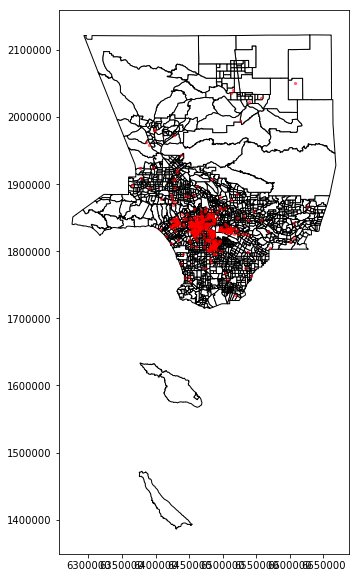

In [34]:
ax = tracts.plot(color='white', edgecolor='black', figsize=(10,10));

# We can now plot the points in our GeoDataFrame
gdf['coordinates'].sample(n=500).plot(ax=ax, markersize=5, alpha=0.5, color='red');

### Do the spatial join

- We'll do a "left" join so we don't lose any points if some of our families don't happen to fall within a census tract – we'll just get a NULL (None) in the CT100 field.
- 'within' just slightly faster operation than 'intersects' or 'contains' – For points in a polygon it shouldn't matter which operation you use

In [35]:
eth_tracts = gpd.sjoin(gdf, tracts, how="left", op='within')

eth_tracts[['familyid','CT00']].head()

,familyid,CT00
0,000106617324,463600
1,000106679098,555103
2,000106273271,900806
3,000106308511,574300
4,000106431883,920043


### Saving only the two fields that we need to output CSV

In [36]:
eth_tracts[['familyid','CT00']].to_csv('la_family_tracts.csv', index=False, encoding='utf-8')

### Alternatively save data to shapefile for easier mapping

I like to put shapefiles in their own directory since a "shapefile" really consists of multiple files, and this makes it easier to keep them together.

- *Creating the directory will give an error if it already exists, so I check whether it's already been created first.*
- *This also happens to be an easy way to create a DBF file of your data!*

In [37]:
if not os.path.exists('data/la_family_SHP'):
	os.mkdir('data/la_family_SHP')
    
eth_tracts[['familyid', 'coordinates', 'CT00']].to_file('data/la_family_SHP/la_family_points.shp')

---

## Geo shape centroid

There is a .centroid property of any geometry shapely (GeoPandas) column
https://gis.stackexchange.com/questions/166820/geopandas-return-lat-and-long-of-a-centroid-point

`tracts[‘geometry’].centroid`

and each of those has a `.x` and `.y` attribute (centroid is a `Point()`)

In [45]:
geoms = tracts.loc[:10,['CT00','geometry']].copy()

In [46]:
geoms.crs

{'proj': 'lcc',
 'lat_0': 33.5,
 'lon_0': -118,
 'lat_1': 34.0333333333333,
 'lat_2': 35.4666666666667,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True,
 'wktext': True}

In [47]:
geoms['geometry'].centroid

0     POINT (6473138.216 1916941.393)
1     POINT (6479969.894 1921132.951)
2     POINT (6473815.754 1914573.486)
3     POINT (6476559.474 1914071.099)
4     POINT (6479779.632 1913100.254)
5     POINT (6472849.530 1910858.903)
6     POINT (6464086.524 1907684.472)
7     POINT (6456608.263 1901932.035)
8     POINT (6469673.720 1924292.753)
9     POINT (6468792.850 1918379.697)
10    POINT (6460368.124 1922514.284)
dtype: geometry

In [50]:
geoms['geometry'].representative_point()

0     POINT (6473185.748 1916971.752)
1     POINT (6479906.139 1921547.000)
2     POINT (6474027.323 1914211.191)
3     POINT (6476432.513 1913970.438)
4     POINT (6479705.038 1911873.063)
5     POINT (6471928.910 1911307.500)
6     POINT (6459991.407 1909057.624)
7     POINT (6457495.012 1901711.565)
8     POINT (6469017.629 1924453.438)
9     POINT (6468528.721 1918128.949)
10    POINT (6463050.896 1921846.483)
dtype: geometry

In [59]:
geoms['geometry'].bounds

,minx,miny,maxx,maxy
0,6.470334e+06,1.915634e+06,6.475587e+06,1.918331e+06
1,6.470023e+06,1.914283e+06,6.489633e+06,1.928791e+06
2,6.471178e+06,1.912769e+06,6.475272e+06,1.915676e+06
3,6.475267e+06,1.912197e+06,6.478236e+06,1.915636e+06
4,6.477592e+06,1.906638e+06,6.481579e+06,1.917116e+06
5,6.464299e+06,1.906934e+06,6.479953e+06,1.915676e+06
6,6.450488e+06,1.903093e+06,6.481022e+06,1.915038e+06
7,6.452057e+06,1.897706e+06,6.460527e+06,1.905800e+06
8,6.465727e+06,1.919632e+06,6.475190e+06,1.929274e+06
9,6.466260e+06,1.916666e+06,6.471660e+06,1.919693e+06


In [48]:
geoms['geometry'].centroid.x

0     6.473138e+06
1     6.479970e+06
2     6.473816e+06
3     6.476559e+06
4     6.479780e+06
5     6.472850e+06
6     6.464087e+06
7     6.456608e+06
8     6.469674e+06
9     6.468793e+06
10    6.460368e+06
dtype: float64

In [49]:
geoms['geometry'].area

0     1.228537e+07
1     1.364394e+08
2     7.019669e+06
3     7.485860e+06
4     2.784498e+07
5     6.757767e+07
6     2.084681e+08
7     3.961631e+07
8     4.713340e+07
9     1.337454e+07
10    7.875528e+07
dtype: float64

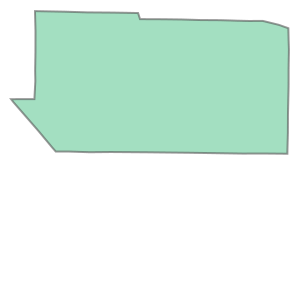

In [57]:
geoms.loc[0,'geometry']

In [42]:
geoms.to_crs(crs='epsg:4326', inplace=True)
geoms['geometry'].centroid

0     POINT (-118.29298 34.25948)
1     POINT (-118.27041 34.27105)
2     POINT (-118.29072 34.25298)
3     POINT (-118.28163 34.25162)
4     POINT (-118.27097 34.24898)
5     POINT (-118.29388 34.24277)
6     POINT (-118.32284 34.23397)
7     POINT (-118.34752 34.21809)
8     POINT (-118.30452 34.27965)
9     POINT (-118.30738 34.26340)
10    POINT (-118.33531 34.27468)
dtype: geometry